# Hierarchical clustering

Hierarchical clustering is a technique that constructs a hierarchy of clusters, represented visually as a dendrogram. It captures multi-scale relationships within the data and does not require pre-specifying the number of clusters.

---

**Computational objective**

Use the built in hierarchical clustering function on ``scipy`` to detect clusters in the Iris dataset.

---

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import pandas as pd

## Definition

### Input

1. A dataset $X = \{x_1, x_2, \dots, x_n\}$, where $x_i \in \mathbb{R}^d$ is a $d$-dimensional data point.

2. A metric $d$ on $X$, with a common choice being the induced **euclidean distance**:
   $$
   d(x_i, x_j) = \sqrt{\sum_{k=1}^d (x_{ik} - x_{jk})^2}.
   $$

3. A **linkage function** $D$, which defines the distance between two clusters $C_1$ and $C_2$. Some common linkage methods are:
    - **Single linkage**:
    $$D(C_1, C_2) = \min_{x \in C_1, y \in C_2} d(x, y)$$
    - **Complete linkage**:
    $$D(C_1, C_2) = \max_{x \in C_1, y \in C_2} d(x, y)$$
    - **Average linkage**:
    $$D(C_1, C_2) = \frac{1}{|C_1||C_2|} \sum_{x \in C_1} \sum_{y \in C_2} d(x, y)$$
    - **Ward's Method**: Minimizes the increase in total within-cluster variance after merging clusters.
    The distance between two clusters is computed based on how much the within-cluster sum of squared deviations (variance) would increase if they were merged.
    Explicitly,
    $$
    D(C_1, C_2) = \frac{|C_1| \cdot |C_2|}{|C_1| + |C_2|} \| \mathbf{c}_1 - \mathbf{c}_2 \|^2
    $$
    where $\mathbf{c}$ denotes the centroid of the cluster.

---

### Process

1. Start with each data point as its own cluster: $\{C_1, C_2, \dots, C_n\}$, where $C_i = \{x_i\}$.
2. At each step:
   - Compute $D(C_i, C_j)$ for all pairs of clusters $(C_i, C_j)$ using the chosen linkage function.
   - Merge the two clusters $C_i$ and $C_j$ with the smallest $D(C_i, C_j)$.
   - Update the set of clusters and distances.
3. Continue until all points are merged into a single cluster, or a specified number of clusters is reached.

---

### Visualization

The hierarchical structure is represented as a **dendrogram**, where:
1. The $y$-axis represents the distance (or dissimilarity) at which clusters are merged.
2. Clusters at a lower height (shorter distance) are more similar than those merged at higher levels.


### Housing Data

We begin by creating a random dataset in $\mathbb{R}^2$ with two clusters.

In [27]:
# Replace 'your_file.csv' with the path or name of your CSV file
df = pd.read_csv('cleaned_data.csv', header=0)

# Display the first few rows to verify the import
df.head()

,Unnamed: 0,ward,beds,baths,DEN,size,parking,exposure,D_mkt,building_age,maint,price,lt,lg
0,0,13,3.0,3,0,3.0,0,1,16.0,9,1087.000000,1821000.0,43.617997,-79.392383
1,1,13,1.0,1,1,1.0,1,2,23.0,3,469.000000,613000.0,43.648968,-79.390031
2,2,13,2.0,2,1,1.0,1,2,12.0,1,767.000000,838000.0,43.641045,-79.375436
3,3,13,2.0,2,0,1.0,1,0,10.0,25,827.000000,935000.0,43.642122,-79.370250
4,4,10,2.0,1,0,1.0,0,0,5.0,1,753.390062,1328000.0,43.692210,-79.365015


In [71]:
df_sub = df[['lt', 'lg', 'price']].copy()
scaling_factor = 10000
scaling_factor = 10000
df_sub['lt'] = df_sub['lt'] * scaling_factor
df_sub['lg'] = df_sub['lg'] * scaling_factor
df_sub.head()

,lt,lg,price
0,436179.970722,-793923.829335,1821000.0
1,436489.684629,-793900.309132,613000.0
2,436410.446660,-793754.357558,838000.0
3,436421.224421,-793702.500866,935000.0
4,436922.099231,-793650.154946,1328000.0


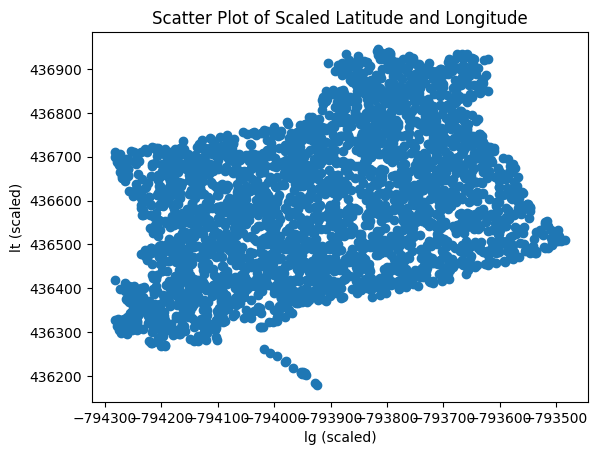

In [72]:
plt.scatter(df_sub['lg'], df_sub['lt'])
plt.xlabel('lg (scaled)')
plt.ylabel('lt (scaled)')
plt.title('Scatter Plot of Scaled Latitude and Longitude')
plt.show()

We will use matplotlib to visualize the data.

Now that we have the data, let us perform hierarchical clustering using the single linkage method. This approach defines the distance between two clusters as the shortest distance between any pair of points, with one point from each cluster (i.e., nearest neighbor).

In [73]:
# 4. Hierarchical clustering on the scaled features
link_scaled = linkage(df_sub[['lt','lg']], method='ward')

Finally we visualize the output as a dendogram noticing that it reflects well our geometric understanding of the data.

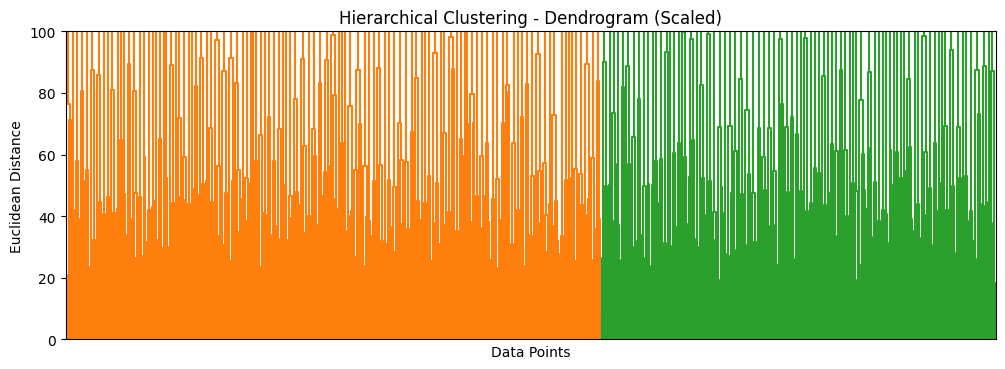

In [74]:
# 5. Plot dendrogram
plt.figure(figsize=(12, 4))
dendrogram(link_scaled, no_labels=True)
plt.ylim(0, 100)  # Adjust the y-limit as needed for readability
plt.title("Hierarchical Clustering - Dendrogram (Scaled)")
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.show()

Let us now study the clusters at a given linkage distance.

In [75]:
# 6. Assign clusters with an example distance threshold
distance = 100  # Adjust as needed for your scaled data
cluster_assignments_scaled = fcluster(link_scaled, t=distance, criterion='distance')
print(f"{max(cluster_assignments_scaled)} clusters at distance {distance}")

# Group labels by cluster
clustered_labels = {}
for i, cluster_id in enumerate(cluster_assignments):
    clustered_labels.setdefault(cluster_id, [])

# Inspect clustered labels
cluster = 1
clustered_labels[cluster][:5] #  First labels in the given cluster

190 clusters at distance 100


[]

In [76]:
def sum_within_cluster_variance(data, cluster_assignments, price_col='price'):
    """
    Returns the sum of within-cluster variance of the 'price' column
    given the cluster assignments.
    """
    unique_clusters = np.unique(cluster_assignments)
    total_variance = 0.0

    for clus_id in unique_clusters:
        cluster_data = data.loc[cluster_assignments == clus_id, price_col]
        
        # Variance is only defined if we have at least 2 data points
        if len(cluster_data) > 1:
            total_variance += cluster_data.var(ddof=1)  # sample variance (N-1 in denominator)

    return total_variance / len(unique_clusters)


Optimal distance = 2700.00 with sum of within-cluster price variance = 303350968049.12


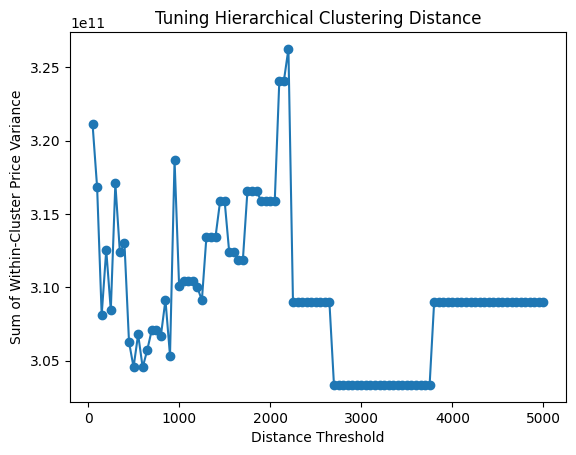

In [79]:
from scipy.cluster.hierarchy import fcluster

# We'll search over a range of distances. You can adjust the start, stop, and number of steps.
distance_values = np.linspace(50, 5000, 100)  # 50 steps between 50 and 5000
scores = []

for dist in distance_values:
    # Get cluster assignments at this distance
    cluster_assignments = fcluster(link_scaled, t=dist, criterion='distance')
    
    # Compute the cluster quality metric (lower is better in this example)
    score = sum_within_cluster_variance(df_sub, cluster_assignments, price_col = 'price')
    scores.append(score)

# Convert to a NumPy array for easier analysis
scores = np.array(scores)

# Identify which distance gave us the best (lowest) score
best_idx = np.argmin(scores)
best_distance = distance_values[best_idx]
best_score = scores[best_idx]

print(f"Optimal distance = {best_distance:.2f} with sum of within-cluster price variance = {best_score:.2f}")

# (Optional) Plot distance vs. our cluster metric
plt.plot(distance_values, scores, marker='o')
plt.title('Tuning Hierarchical Clustering Distance')
plt.xlabel('Distance Threshold')
plt.ylabel('Sum of Within-Cluster Price Variance')
plt.show()


In [87]:
# Re-run cluster assignment using the optimal distance
best_distance = 128
optimal_cluster_assignments = fcluster(link_scaled, t=best_distance, criterion='distance')

# For convenience, add the cluster labels back into the dataframe
df['cluster_id'] = optimal_cluster_assignments

print("Number of clusters formed:", len(np.unique(optimal_cluster_assignments)))

# Quick check of the first 5 rows, to see cluster assignments
df.head()


Number of clusters formed: 149


,Unnamed: 0,ward,beds,baths,DEN,size,parking,exposure,D_mkt,building_age,maint,price,lt,lg,cluster_id
0,0,13,3.0,3,0,3.0,0,1,16.0,9,1087.000000,1821000.0,43.617997,-79.392383,65
1,1,13,1.0,1,1,1.0,1,2,23.0,3,469.000000,613000.0,43.648968,-79.390031,75
2,2,13,2.0,2,1,1.0,1,2,12.0,1,767.000000,838000.0,43.641045,-79.375436,140
3,3,13,2.0,2,0,1.0,1,0,10.0,25,827.000000,935000.0,43.642122,-79.370250,139
4,4,10,2.0,1,0,1.0,0,0,5.0,1,753.390062,1328000.0,43.692210,-79.365015,90


In [89]:
df.to_csv("data_clusters.csv", index=False)
